# はじめに
表形式データの分類モデルを構築します。

### 概要
- adultデータセットを用いて収入を予測するモデルを構築します。
- モデルはFT-Transformerを使用します。

# FT-Transformer
FT-Transformerは、Transformerを表形式データに適用できるように拡張した手法で、Feature TokenizerとTransformerから構成されます。  
下の図は提案論文の図です。  
Feature Tokenizerでは、入力の各要素をembeddingに変換します。  
それに[CLS]トークンを追加し、Transformerに入力します。  
[CLS]トークンに対応するTransfomrmerの出力を予測に用います。  






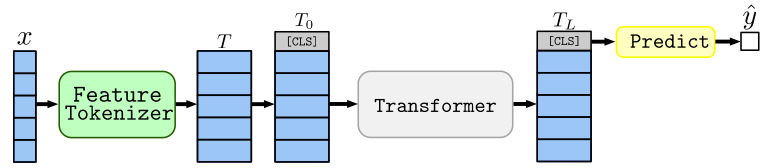


### Feature Tokenizer
連続値またはカテゴリ変数を連続値のベクトルであるembeddingに変換します（下記提案論文の図(a)）。  
連続値の場合は、重みを掛けてバイアス項を足すことで変換します。  
カテゴリ変数の場合は、カテゴリごとの重みにバイアス項を足すことで変換します。  
変数ごとに変換を行い、その結果を結合して、トークン列として扱います。  


### Transformer
主要な処理としては、multi-head self-attentionとposition-wise feed-forwardで構成されています（下記提案論文の図(b)）。  
自然言語では、positional encodingも用いますが、表形式のデータでは、変数の順序に意味はないので、FT-Transformerでは用いません。  

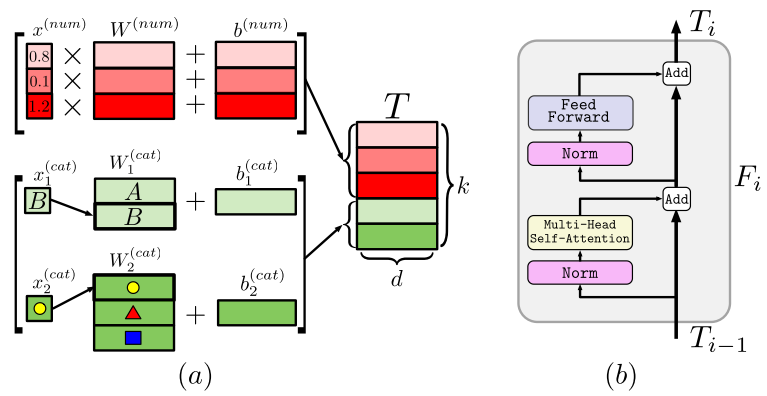

self-attentionでは、各tokenのembeddingを、関連の強いtokenの影響を受けながら更新します。  
下記は[解説記事](https://jalammar.github.io/illustrated-transformer/)の図です。  
multi-head self-attentionでは、複数パターンのattentionを用いて、更新を行います。

position-wise feed-forwardでは、単語ごとに全結合層での伝播を行います。  

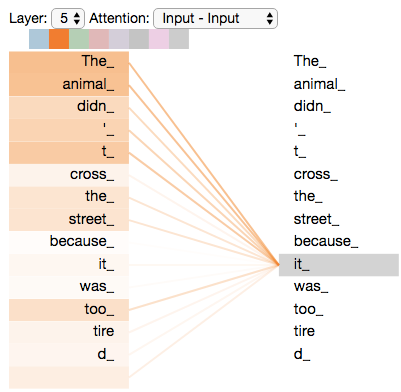

# 実装
### 1. ライブラリのインポート

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

!pip install pytorch_tabular
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split

import torch

### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
!nvidia-smi

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch: 2.1.0+cu121
Sat Jan 20 06:10:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |            

### 3. データセットの用意
adultデータセットをダウンロードして、学習に使用できる形式に整形します。

In [ ]:
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets['income']

y = y.replace({'<=50K.': 0, '<=50K':0, '>50K.': 1, '>50K': 1})

# カテゴリ変数の特定
categorical = X.columns[X.dtypes == 'object'].tolist()
continuous = X.columns[X.dtypes != 'object'].tolist()


# 教師データとテストデータにランダムに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print(X_train.shape, X_test.shape)
print(collections.Counter(y_train), collections.Counter(y_test))

X_train['income'] = y_train
X_test['income'] = y_test


(34189, 14) (14653, 14)
Counter({0: 26046, 1: 8143}) Counter({0: 11109, 1: 3544})


### 4. ニューラルネットワークの定義  
今回は5層の全結合ニューラルネットワークを用います。

In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

data_config = DataConfig(
    target=['income'],
    continuous_cols=continuous,
    categorical_cols=categorical,
)
trainer_config = TrainerConfig(
    auto_lr_find=False,
    batch_size=128,
    max_epochs=100,
)
optimizer_config = OptimizerConfig(
    optimizer_params = {'weight_decay':1e-4}
)

model_config = FTTransformerConfig(
    task="classification",
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)


INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off


### 5. 学習
ニューラルネットワークの学習を行います。  


In [ ]:
tabular_model.fit(train=X_train)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: FTTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ FTTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer      │  4.3 K │
│ 2 │ _head            │ LinearHead            │     66 │
│ 3 │ loss             │ CrossEntropyLoss      │      0 │
└───┴──────────────────┴───────────────────────┴────────┘

Trainable params: 275 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 275 K                                                                                                
Total estimated model params size (MB): 1

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model


### 6. 学習結果の表示
テストデータの損失と精度を評価します。

In [ ]:
result = tabular_model.evaluate(X_test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8548420071601868     │
│         test_loss         │    0.31522735953330994    │
└───────────────────────────┴───────────────────────────┘

# おわりに
### 今回の結果
今回の設定では、テスト精度は85%程度となりました。  
全結合ニューラルネットワークと同等の精度となっています。  

### 次にやること  
他の表形式データのために提案されたニューラルネットワークも試してみようと思います。  

### 参考資料  
- Y. Gorishniy et al., Revisiting Deep Learning Models for Tabular Data, NeurIPS, 2021.  
- The Illustrated Transformer  
https://jalammar.github.io/illustrated-transformer/  
- PyTorch Tabular  
https://pytorch-tabular.readthedocs.io/en/latest/
